<a href="https://colab.research.google.com/github/alex-mat-s/ArchNN-23/blob/main/ArchNN'22_HW_4_Matveeva_j4234c.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Deep Convolutional GAN (DCGAN) implementation**

In this laboratory work, you will be implementing the Deep Convolutional Generative Adversarial Network architecture (DCGAN). This task is based on the paper `Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks`. This paper by Alec Radford, Luke Metz, and Soumith Chintala was released in 2016 and has become the baseline for many Convolutional GAN architectures in deep learning. You will learn about the DCGAN architecture from the paper. After that, you will implement the model using PyTorch deep learning framework.

You will work with the CIFAR10 dataset and try to train models for generating similar images.

In [1]:
import torch
import torch.nn as nn

if torch.cuda.is_available():
    print(torch.cuda.get_device_name())

Tesla T4


In [2]:
# Create input and output folders
!mkdir input
!mkdir outputs

### **No Max Pooling**
DCGAN architecture is a fully convolutional network. This means that we will not use any max-pooling for downsampling. All of the operations will be through strided convolutions only.

### **Using Batch Normalization**
We will use batch normalization while building both, the discriminator and the generator. This mainly tackles two problems in DCGAN and in deep neural networks in general.

It normalizes the input to each unit of a layer.
It also helps to deal with poor initialization that may cause problems in gradient flow.

### **ReLU, LeakyReLU, and Tanh Activations**
We will use the ReLU activation function in all the layers of the generator, except for the last one. For the last convolutional layer, we will use Tanh activation function.

For the discriminator, we will use LeakyReLU for all the convolutional layer after applying batch normalization.

The above are the architectural details that the authors have provided in the paper. Applying these successfully while building our DCGAN model will surely help in more stable training.

### **Hyperparameters to Consider While Training**
Now, we will learn about the different parameters and hyperparameters that we can use while training DCGAN. Using the hyperparameter values as provided by the authors will give us the best results while training.

The very first one is the batch size. The authors used a batch size of $128$ for training DCGAN. While implementing the code, will use the same batch size as well.

We will also carry out weight initialization for the generator and discriminator networks. We will initialize the weights from a zero-centered Normal Distribution with a standard deviation of 0.02.

For the discriminator network, we will use the LeakyReLU activation. We will set the slope of the LeakyReLU activation to 0.2.

We will use the Adam optimizer for training DCGAN. The learning rate of Adam optimizer is going to be 0.0002. The Adam optimizer has a default momentum value β1 of 0.9. Instead of 0.9, we will set the value of β1 to 0.5. This helps in more stable training and faster convergence.

## **Generator**

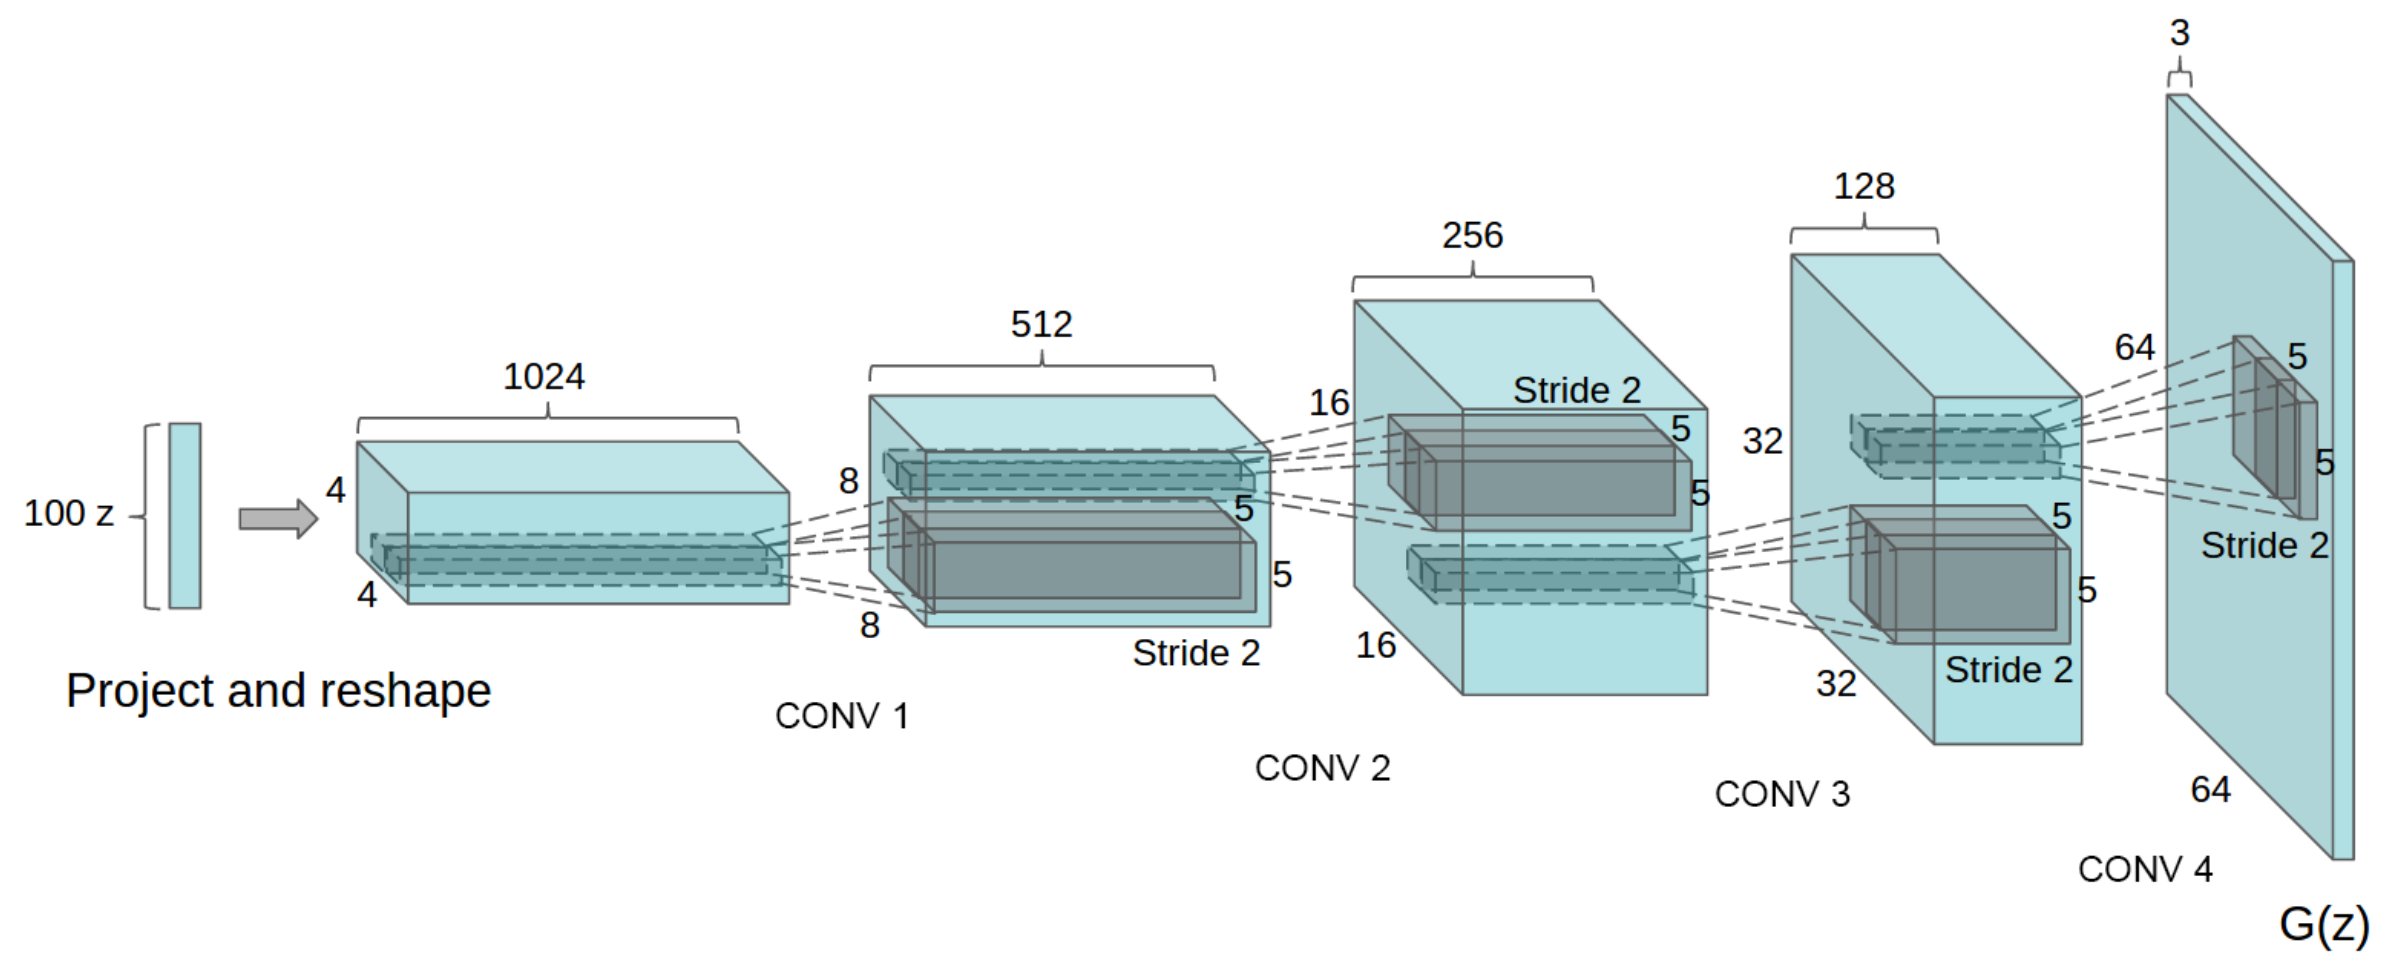

**Figure 1.** The generator network in the DCGAN model (Source).

You can see that we have only convolutional layers in the network.

### **Generator architectural details**

* First, we give the generator a 100-dimensional noise vector as the input.
* After that, we project and reshape the input.
* Then we have four convolution operations. Each time we get an increment in height and width. At the same time, the channels keep on reducing.
* The kernel size will be 4×4.
* After the first convolution operation, we have 512 output channels. This keeps on reducing with each convolution operation. After the third one, the output channels are 128.
* By the end, we have a generated image of 64×64 dimensions and three output channels.
* Except for the first convolution layer, all the other layers have a stride of 2.


In [7]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz # input to the first convolution
        self.main = nn.Sequential(

            nn.ConvTranspose2d(nz, 1024, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(1024),
            nn.ReLU(True),

            nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

## **Discriminator**
The discriminator mode will almost be the reverse of the generator model.
Remember that we need the discriminator to classify whether an image is real (1) or fake (0), so you should choose appropriate activation function on the last layer.

In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),

            nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),

            nn.Conv2d(1024, 1, kernel_size=4, stride=1, padding=0),
            nn.Flatten(),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [9]:
from torchvision.utils import save_image

''' PLEASE DO NOT CHANGE THE CODE OF THIS SECTION'''

# set the computation device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def label_real(size):
    """
    Fucntion to create real labels (ones)
    :param size: batch size
    :return real label vector
    """
    data = torch.ones(size, 1)
    return data.to(device)

def label_fake(size):
    """
    Fucntion to create fake labels (zeros)
    :param size: batch size
    :returns fake label vector
    """
    data = torch.zeros(size, 1)
    return data.to(device)

def create_noise(sample_size, nz):
    """
    Fucntion to create noise
    :param sample_size: fixed sample size or batch size
    :param nz: latent vector size
    :returns random noise vector
    """
    return torch.randn(sample_size, nz, 1, 1).to(device)

def save_generator_image(image, path):
    """
    Function to save torch image batches
    :param image: image tensor batch
    :param path: path name to save image
    """
    save_image(image, path, normalize=True)

def weights_init(m):
    """
    This function initializes the model weights randomly from a
    Normal distribution. This follows the specification from the DCGAN paper.
    https://arxiv.org/pdf/1511.06434.pdf
    """
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [16]:
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

import numpy as np
import matplotlib
from matplotlib import pyplot as plt

from tqdm import tqdm
matplotlib.style.use('ggplot')

# learning parameters / configurations according to described parameters
image_size = 64
batch_size = 128
nz = 100

''' YOUR CODE HERE'''
beta1 = 0.5 # beta1 value for Adam optimizer
lr = 0.0002 # learning rate according to paper
sample_size = 128 # fixed sample size
epochs = 20 # number of epoch to train

# set the computation device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# image transforms
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),
    (0.5, 0.5, 0.5)),
])

# prepare the data
train_data = datasets.CIFAR10(
    root='input/data',
    train=True,
    download=True,
    transform=transform
)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

Files already downloaded and verified


In [17]:
# initialize generator and discriminator models
''' YOUR CODE HERE'''
generator = Generator(nz)
discriminator = Discriminator()

# initialize generator and discriminator weights
''' YOUR CODE HERE'''
generator.apply(weights_init).to(device)
discriminator.apply(weights_init).to(device)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.2)
    (4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.2)
    (6): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): LeakyReLU(negative_slope=0.2)
    (8): Conv2d(1024, 1, kernel_size=(4, 4), stride=(1, 1))
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Sigmoid()
  )
)

In [18]:
# optimizers for generator and discriminator
''' YOUR CODE HERE'''
optim_g = torch.optim.Adam(generator.parameters(), lr=lr, betas = (beta1, 0.999))
optim_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas = (beta1, 0.999))

# loss function
criterion = nn.BCELoss()

losses_g = [] # to store generator loss after each epoch
losses_d = [] # to store discriminator loss after each epoch

In [19]:
# function to train the discriminator network
def train_discriminator(optimizer, data_real, data_fake):
    b_size = data_real.size(0)
    # get the real label vector
    real_label = label_real(b_size)
    # get the fake label vector
    fake_label = label_fake(b_size)

    optimizer.zero_grad()

    # get the outputs by doing real data forward pass
    ''' YOUR CODE HERE'''
    output_real = discriminator(data_real)
    loss_real = criterion(output_real, real_label)

    # get the outputs by doing fake data forward pass
    ''' YOUR CODE HERE'''
    output_fake = discriminator(data_fake)
    loss_fake = criterion(output_fake, fake_label)

    # compute gradients of real loss
    ''' YOUR CODE HERE'''
    loss_real.backward()
    # compute gradients of fake loss
    ''' YOUR CODE HERE'''
    loss_fake.backward()
    # update discriminator parameters
    ''' YOUR CODE HERE'''
    optimizer.step()

    return loss_real + loss_fake

In [20]:
# function to train the generator network
def train_generator(optimizer, data_fake):
    b_size = data_fake.size(0)
    # get the real label vector
    real_label = label_real(b_size)

    optimizer.zero_grad()

    # output by doing a forward pass of the fake data through discriminator
    ''' YOUR CODE HERE'''
    output = discriminator(data_fake)
    loss = criterion(output, real_label)

    # compute gradients of loss
    ''' YOUR CODE HERE'''
    loss.backward()
    # update generator parameters
    ''' YOUR CODE HERE'''
    optimizer.step()

    return loss

In [21]:
# create the noise vector
''' YOUR CODE HERE'''
noise = create_noise(batch_size, nz).to(device)

generator.train()
discriminator.train()

for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    for bi, data in tqdm(enumerate(train_loader), total=int(len(train_data)/train_loader.batch_size)):
        image, _ = data
        image = image.to(device)
        b_size = len(image)

        # forward pass through generator to create fake data
        ''' YOUR CODE HERE'''
        data_fake = generator(create_noise(b_size, nz).to(device))
        data_real = image

        loss_d += train_discriminator(optim_d, data_real, data_fake)
        data_fake = generator(create_noise(b_size, nz).to(device))
        loss_g += train_generator(optim_g, data_fake)

    # final forward pass through generator to create fake data
    # after training for current epoch
    ''' YOUR CODE HERE'''
    generated_img = generator(noise)

    # save the generated torch tensor models to disk
    ''' PLEASE DO NOT CHANGE THE CODE OF THIS SECTION'''
    save_generator_image(generated_img, f"outputs/gen_img{epoch}.png")
    epoch_loss_g = loss_g / bi # total generator loss for the epoch
    epoch_loss_d = loss_d / bi # total discriminator loss for the epoch
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)

    print(f"Epoch {epoch+1} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

print('DONE TRAINING')
# save the model weights to disk
torch.save(generator.state_dict(), 'outputs/generator.pth')

391it [04:03,  1.61it/s]


Epoch 1 of 20
Generator loss: 2.44313169, Discriminator loss: 0.93941575


391it [04:05,  1.60it/s]


Epoch 2 of 20
Generator loss: 1.85125971, Discriminator loss: 0.99342418


391it [04:04,  1.60it/s]


Epoch 3 of 20
Generator loss: 1.83723390, Discriminator loss: 1.01626980


391it [04:05,  1.60it/s]


Epoch 4 of 20
Generator loss: 1.79582787, Discriminator loss: 0.99323177


391it [04:05,  1.59it/s]


Epoch 5 of 20
Generator loss: 1.53306890, Discriminator loss: 1.06680202


391it [04:05,  1.59it/s]


Epoch 6 of 20
Generator loss: 1.42903066, Discriminator loss: 1.10632956


391it [04:05,  1.59it/s]


Epoch 7 of 20
Generator loss: 1.52949095, Discriminator loss: 1.05796933


391it [04:05,  1.59it/s]


Epoch 8 of 20
Generator loss: 1.53514850, Discriminator loss: 1.03611267


391it [04:06,  1.59it/s]


Epoch 9 of 20
Generator loss: 1.43647969, Discriminator loss: 1.07936025


391it [04:05,  1.59it/s]


Epoch 10 of 20
Generator loss: 1.37284851, Discriminator loss: 1.10165179


391it [04:05,  1.59it/s]


Epoch 11 of 20
Generator loss: 1.36721170, Discriminator loss: 1.10167456


391it [04:05,  1.59it/s]


Epoch 12 of 20
Generator loss: 1.40225112, Discriminator loss: 1.07829607


391it [04:05,  1.59it/s]


Epoch 13 of 20
Generator loss: 1.35705650, Discriminator loss: 1.11370444


391it [04:05,  1.59it/s]


Epoch 14 of 20
Generator loss: 1.46048295, Discriminator loss: 1.05012393


391it [04:05,  1.59it/s]


Epoch 15 of 20
Generator loss: 1.48480463, Discriminator loss: 1.02511120


391it [04:05,  1.59it/s]


Epoch 16 of 20
Generator loss: 1.47916532, Discriminator loss: 1.04261279


391it [04:05,  1.59it/s]


Epoch 17 of 20
Generator loss: 1.48810184, Discriminator loss: 1.02169406


391it [04:05,  1.60it/s]


Epoch 18 of 20
Generator loss: 1.54931068, Discriminator loss: 0.99518389


391it [04:05,  1.60it/s]


Epoch 19 of 20
Generator loss: 1.50814867, Discriminator loss: 1.00220311


391it [04:05,  1.59it/s]


Epoch 20 of 20
Generator loss: 1.59514368, Discriminator loss: 0.98613667
DONE TRAINING


In [23]:
# Convert losses variables into numpy arrays for visualization
''' YOUR CODE HERE'''
losses_g_array = list(map(lambda x: x.detach().cpu().numpy(), losses_g))
losses_d_array = list(map(lambda x: x.detach().cpu().numpy(), losses_d))

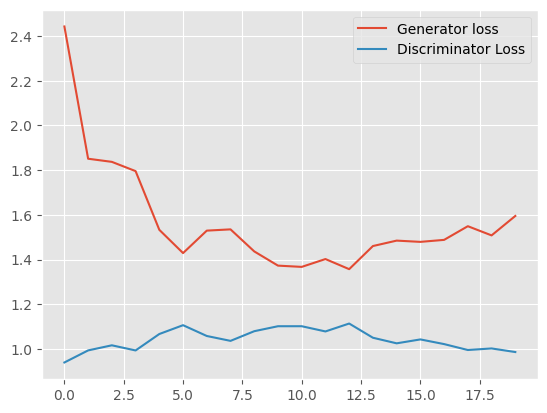

In [24]:
# plot and save the generator and discriminator loss
''' PLEASE DO NOT CHANGE THE CODE OF THIS SECTION'''
plt.figure()
plt.plot(losses_g_array, label='Generator loss')
plt.plot(losses_d_array, label='Discriminator Loss')
plt.legend()
plt.savefig('outputs/loss.png')
plt.show()

In [25]:
!ls

input  outputs	sample_data


In [26]:
!cd outputs; ls

generator.pth  gen_img12.png  gen_img16.png  gen_img1.png  gen_img5.png  gen_img9.png
gen_img0.png   gen_img13.png  gen_img17.png  gen_img2.png  gen_img6.png  loss.png
gen_img10.png  gen_img14.png  gen_img18.png  gen_img3.png  gen_img7.png
gen_img11.png  gen_img15.png  gen_img19.png  gen_img4.png  gen_img8.png


In [27]:
import cv2

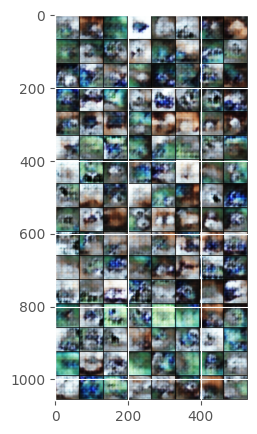

In [32]:
gen_img = cv2.imread('outputs/gen_img4.png')
plt.figure(figsize=(15, 5))
plt.imshow(gen_img)
plt.show()

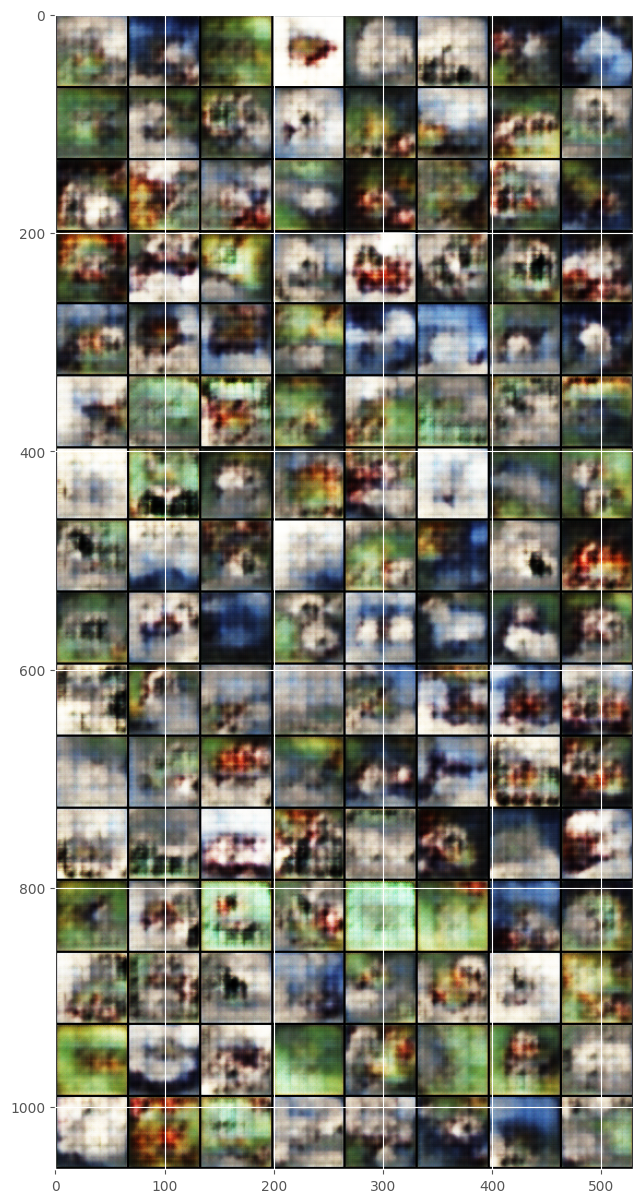

In [33]:
plt.figure(figsize=(20, 15))
plt.imshow(cv2.cvtColor(gen_img, cv2.COLOR_BGR2RGB))
plt.grid('off')
plt.show()